# Activity for week 3: How to plot and examine metadata for a NEON RGB Camera Image

created on 6/27/2018 by Amanda M. Schwantes


#### Check to confirm that Python 3.5 is running and change my working directory

In [1]:
import sys
print(sys.version)

path1 = "C:\\Users\\Amanda Schwantes\\Documents\\workshopNEON2018\\week3prior\\"
import os
os.chdir(path1)
print(os.getcwd())

3.5.5 |Anaconda custom (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
C:\Users\Amanda Schwantes\Documents\workshopNEON2018\week3prior


#### Import the libaries and functions needed for the analysis

In [2]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def RGBraster2array(RGB_geotif):
    """RGBraster2array reads in a NEON AOP geotif file and returns 
    a numpy array, and header containing associated metadata with spatial information.
    --------
    Parameters
        RGB_geotif -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    array:
        numpy array of geotif values
    metadata:
        dictionary containing the following metadata (all strings):
            array_rows
            array_cols
            bands
            driver
            projection
            geotransform 
            pixelWidth 
            pixelHeight 
            extent
            noDataValue  
            scaleFactor 
    --------
    Example Execution:
    --------
    RGB_geotif = '2017_SERC_2_368000_4306000_image.tif'
    RGBcam_array, RGBcam_metadata = RGBraster2array(RGB_geotif) """

    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

#### Load the image from our working directory and run the function that converts our raster file to an array

In [4]:
RGB_geotif = './2017_SERC_2_368000_4306000_image.tif'
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

#### Prints the dimensions of the array

In [5]:
SERC_RGBcam_array.shape

(10000, 10000, 3)

#### prints the metadata (information that is stored in the header)

In [6]:
for key in sorted(SERC_RGBcam_metadata.keys()):
  print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


#### The function below plots a RGB image when a 3-band image is provided

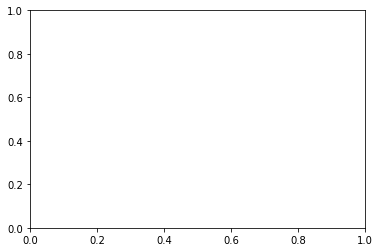

In [7]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):

    '''plot_band_array reads in and plots a single band or an rgb band combination of a reflectance array
    --------
    Parameters
    --------
        band_array: flightline array of reflectance values, created from h5refl2array function
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) - use metadata['extent'] from h5refl2array function
        colorlimit: range of values to plot (min,max). Best to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: string, optional; plot title
        cmap_title: string, optional; colorbar title
        colormap: string, optional; see https://matplotlib.org/examples/color/colormaps_reference.html for list of colormaps
    --------
    Returns 
        plots array of single band or RGB if given a 3-band 
    --------
    Example:
    --------
    plot_band_array(SERC_RGBcam_array, 
                    SERC_RGBcam_metadata['extent'],
                    (1,255),
                    title='SERC RGB Camera Tile',
                    cbar='off')'''

    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

#### We then plot our RGB image

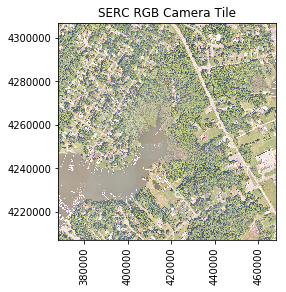

In [8]:
plot_band_array(SERC_RGBcam_array,
                SERC_RGBcam_metadata['extent'],
                (1,255),
                title='SERC RGB Camera Tile',
                cbar='off') 

#### Lastly, we plot a histogram of the first band: red

Text(0,0.5,'Frequency')

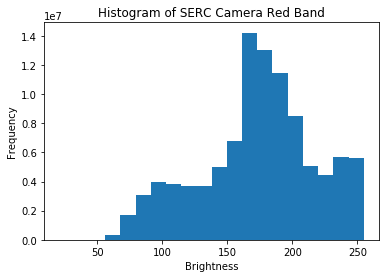

In [9]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),20);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

***
# Now for the challenge questions


#### (1) Green and Blue band histograms  
__Asumptions__ are that the second band is green, and the third band is blue, based on the name of the file. This also seems to be the case based on the outputs of the plots below. 

Text(0,0.5,'Frequency')

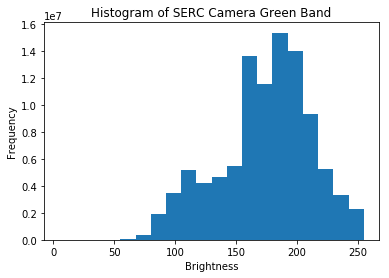

In [10]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),20);
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

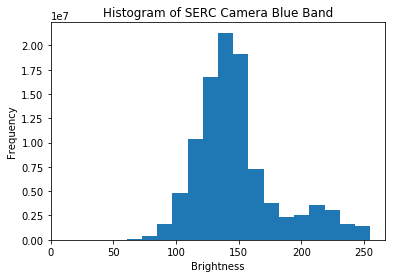

In [11]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),20);
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

#### (2a) Min and Max reflectance for each band
To calculate the min and max reflectance for each band we can use the np.amin() and np.amax() functions.

In [12]:
B1min = np.amin(SERC_RGBcam_array[:,:,0])
B2min = np.amin(SERC_RGBcam_array[:,:,1])
B3min = np.amin(SERC_RGBcam_array[:,:,2])

B1max = np.amax(SERC_RGBcam_array[:,:,0])
B2max = np.amax(SERC_RGBcam_array[:,:,1])
B3max = np.amax(SERC_RGBcam_array[:,:,2])
                
print("Band 1: reflectance ranges from " + str(B1min) + " to " + str(B1max))
print("Band 2: reflectance ranges from " + str(B2min) + " to " + str(B2max))
print("Band 3: reflectance ranges from " + str(B3min) + " to " + str(B3max))

Band 1: reflectance ranges from 21 to 255
Band 2: reflectance ranges from 5 to 255
Band 3: reflectance ranges from 12 to 255


#### (2b) Projection
Looking at the metadata the projection seems to be "WGS 84 / UTM zone 18N". Therefore, the UTM zone of the data is "18N".

In [13]:
print(SERC_RGBcam_metadata['projection'])


PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


#### (2c) Plot each band seperately
We can use the min and max values we calculate above as inputs into the SERC_RGBcam_array() function. I also turned on the color bar and changed the color legends to reflect which band was being mapped.

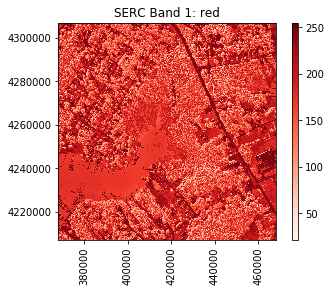

In [14]:
plot_band_array(SERC_RGBcam_array[:,:,0],
                SERC_RGBcam_metadata['extent'],
                (B1min,B1max),
                title='SERC Band 1: red',
                cbar='on',
                colormap='Reds') 

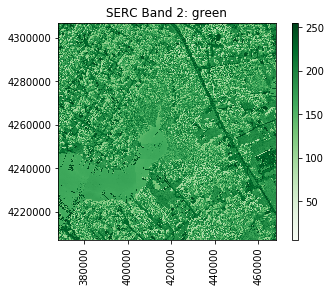

In [15]:
plot_band_array(SERC_RGBcam_array[:,:,1],
                SERC_RGBcam_metadata['extent'],
                (B2min,B2max),
                title='SERC Band 2: green',
                cbar='on',
                colormap='Greens')

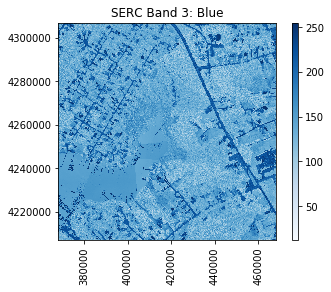

In [16]:
plot_band_array(SERC_RGBcam_array[:,:,2],
                SERC_RGBcam_metadata['extent'],
                (B3min,B3max),
                title='SERC Band 3: Blue',
                cbar='on',
                colormap='Blues')